<a href="https://colab.research.google.com/github/jimbrig-work/Collab-Notebooks/blob/main/LTC_ClaimTermination_20210507.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CLAIM TERMINATIONS STUDY**


In [ ]:
import io

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras import Model
from keras.losses import Loss
from tensorflow.python.keras.utils.vis_utils import plot_model

from sklearn.model_selection import train_test_split

In [ ]:
_EPSILON = 1e-08

##### USER-DEFINED FUNCTIONS
def log(x):
    return tf.math.log(x + _EPSILON)

def div(x, y):
    return tf.div(x, (y + _EPSILON))

# I. Data Prep

**Load and Preprocess the Dataset**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Claims_test.csv to Claims_test.csv


In [ ]:
df = pd.read_csv(io.BytesIO(uploaded['Claims_test.csv']), index_col=0) #encoding='cp1252')
print(df.shape)
# df.head()

(261770, 27)


In [ ]:
df['Incur_Age'] = df['CLM_INCUR_YR'] - df['YOB']

#df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'].value_counts()
df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] = np.where((df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] == 'Arthritis') |
                                                                (df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] == 'Stroke') | 
                                                                (df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'] == 'Unknown'),
                                                                'Other',
                                                                df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'])
dummies = pd.get_dummies(df['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'], prefix='OrigDiagnosis')
df.drop(['ORIGINAL_PRECIPITATING_ICD9_OR_ICD10_DIAGNOSIS'], axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

underlying_list = df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'].value_counts()
underlying_list = underlying_list[underlying_list > 7000].index.to_list()
df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'] = np.where(np.isin(df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'],underlying_list),
                                                                      df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'],
                                                                      'Other')
dummies = pd.get_dummies(df['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'], prefix='UnderlyingDiagnosis')
df.drop(['PRIMARY_UNDERLYING_CONDITION_ICD9_OR_ICD10_DIAGNOSIS'], axis=1, inplace=True)
df = pd.concat([df, dummies], axis=1)

# Time: quarterly for 5 years, then annual
Time_bins = [0,91,182,273,365,
             456,547,638,730,
             821,912,1003,1095,
             1187,1278,1369,1461,
             1552,1643,1734,1826,
             2191,2556,2922,3287,3652,4017,4383,4748,5113,5478]
Time_bins_labels = list(range(1,len(Time_bins)))

dic_K = {1:1, 2:2, 3:0, 4:0, 5:0, 6:0}
df['TerminationReason']=df['CLAIM_STATUS'].map(dic_K)
df['Time_of_Event'] = pd.cut(df['Claim_Duration'], bins=Time_bins, labels=Time_bins_labels) 

df.drop(['Num_Claims','Claim_Duration','LEVEL_OF_CARE_FOR_THIS_PAYMENT','CLAIM_STATUS','PLCY_ID','YOB','ZIPCD_RES_CLM'], 
        axis=1, inplace=True)

df.dropna(subset=['Time_of_Event'], inplace=True)
df['PAID_UP_OPTION_INDICATOR'] = df['PAID_UP_OPTION_INDICATOR'].fillna(0)

df.dropna(inplace=True)

print(df.shape)
df.sample(5)

(226008, 36)


,ISSUE_AGE,GNDR,YR_OF_ISSUE,POLICY_TYPE,TQ_IND,BENEFIT_PAYMENT_TYPE,COVERAGE_TYPE,SHARED_BENEFITS_INDICATOR,FORM_OF_OVERALL_CARE_WAITING_PERIOD_ELIMINATION_PERIOD_DEDUCTIBLE_AMOUNT,OVERALL_CARE_WAITING_PERIOD_ELIMINATION_PERIOD_DEDUCTIBLE_AMOUNT,PAID_UP_OPTION_INDICATOR,CLM_INCUR_YR,ORIGINAL_LEVEL_OF_CARE_FOR_THIS_CLAIM,BENEFIT_ELIGIBILITY_SATISFIED,MARITAL_STATUS_AT_TIME_THAT_CLAIM_INCURRED,COGNITIVE_IMPAIRMENT,COORDINATION_OFFSET_WITH_MEDICARE,COORDINATION_OFFSET_WITH_OTHER_COVERAGE,Incur_Age,OrigDiagnosis_Alzheimer’s and Dementia,OrigDiagnosis_Cancer,OrigDiagnosis_Circulatory,OrigDiagnosis_Injury,OrigDiagnosis_Nervous System,OrigDiagnosis_Other,UnderlyingDiagnosis_BRAIN/CNS,UnderlyingDiagnosis_CANCER/TUMOR,UnderlyingDiagnosis_CARDIOVASCULAR,UnderlyingDiagnosis_CONGESTIVE FAILURE,UnderlyingDiagnosis_EMPHYSEMA,UnderlyingDiagnosis_MENTAL,UnderlyingDiagnosis_MUSCULOSKELETAL,UnderlyingDiagnosis_OBS,UnderlyingDiagnosis_Other,TerminationReason,Time_of_Event
CLM_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1248638,67,1,2000,11,1,3,6,1,1,100,0.0,2013.0,1,2,1,1,1,0,81.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,3
1240255,68,1,1988,11,3,2,1,0,1,20,0.0,2006.0,1,1,2,2,2,0,87.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,2,4
1066216,67,1,2002,11,1,3,6,0,1,100,0.0,2004.0,2,2,2,1,1,0,81.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,8
1185320,64,1,2001,11,1,3,6,0,1,100,0.0,2001.0,3,2,1,1,1,0,78.0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,2,3
1034142,64,1,1996,11,1,3,6,0,1,100,0.0,1999.0,3,1,2,2,1,0,67.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1


**Additional Data Prep**
- Normalize data
- Create masks (Indicator functions)
- Split data into train and test


In [ ]:
# Source: https://github.com/chl8856/DeepHit/blob/master/class_DeepHit.py

def f_get_Normalization(X, norm_mode):
    num_Record, num_Feature = np.shape(X)

    if norm_mode == 'standard': #zero mean unit variance
        for j in range(num_Feature):
            if np.std(X[:,j]) != 0:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))/np.std(X[:,j])
            else:
                X[:,j] = (X[:,j] - np.mean(X[:, j]))
    elif norm_mode == 'normal': #min-max normalization
        for j in range(num_Feature):
            X[:,j] = (X[:,j] - np.min(X[:,j]))/(np.max(X[:,j]) - np.min(X[:,j]))
    else:
        print("INPUT MODE ERROR!")

    return X

### MASK FUNCTIONS
'''
    fc_mask2      : To calculate LOSS_1 (log-likelihood loss)
    fc_mask3      : To calculate LOSS_2 (ranking loss)
'''
def f_get_fc_mask2(time, label, num_Event, num_Category):
    '''
        mask4 is required to get the log-likelihood loss
        mask4 size is [N, num_Event, num_Category]
            if not censored : one element = 1 (0 elsewhere)
            if censored     : fill elements with 1 after the censoring time (for all events)
    '''
    mask = np.zeros([np.shape(time)[0], num_Event, num_Category]) # for the first loss function
    for i in range(np.shape(time)[0]):
        if label[i,0] != 0:  #not censored
            mask[i,int(label[i,0]-1),int(time[i,0])] = 1
        else: #label[i,2]==0: censored
            mask[i,:,int(time[i,0]+1):] =  1 #fill 1 until from the censoring time (to get 1 - \sum F)
    return mask


def f_get_fc_mask3(time, meas_time, num_Category):
    '''
        mask5 is required calculate the ranking loss (for pair-wise comparision)
        mask5 size is [N, num_Category].
        - For longitudinal measurements:
             1's from the last measurement to the event time (exclusive and inclusive, respectively)
             denom is not needed since comparing is done over the same denom
        - For single measurement:
             1's from start to the event time(inclusive)
    '''
    mask = np.zeros([np.shape(time)[0], num_Category]) # for the first loss function
    if np.shape(meas_time):  #lonogitudinal measurements
        for i in range(np.shape(time)[0]):
            t1 = int(meas_time[i, 0]) # last measurement time
            t2 = int(time[i, 0]) # censoring/event time
            mask[i,(t1+1):(t2+1)] = 1  #this excludes the last measurement time and includes the event time
    else:                    #single measurement
        for i in range(np.shape(time)[0]):
            t = int(time[i, 0]) # censoring/event time
            mask[i,:(t+1)] = 1  #this excludes the last measurement time and includes the event time
    return mask

In [ ]:
data = np.asarray(df.iloc[:,:-2])
label = np.asarray(df[['TerminationReason']])
time = np.asarray(df[['Time_of_Event']])

data = f_get_Normalization(data, 'standard')

num_Category = int(np.max(time)) + 1
num_Event = int(len(np.unique(label)) - 1) #only count the number of events (do not count censoring as an event)
x_dim = np.shape(data)[1]

mask1 = f_get_fc_mask2(time, label, num_Event, num_Category)
mask2 = f_get_fc_mask3(time, -1, num_Category)

(tr_data,te_data, tr_time,te_time, tr_label,te_label, 
 tr_mask1,te_mask1, tr_mask2,te_mask2)  = train_test_split(data, time, label, mask1, mask2, test_size=0.20) 

# II. Model

“DeepHit” is a survival analysis model that takes competing risks into considerations.  It was introduced in a paper by Changhee Lee, William R. Zame, Jinsung Yoon, Mihaela van der Schaar in April 2018.

DeepHit trains a neural network to learn the
estimated joint distribution of of survival time and event,
while capturing the right-censored nature inherent in survival
data.  The events of interest in our analysis include Recovery and Death.  All other events are treated as right-censoring.

The diagram below shows the architecture of the model.

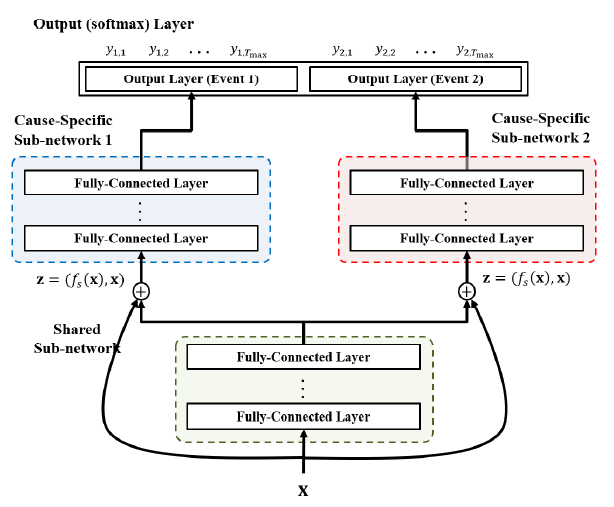

In [ ]:
class DeepHit(Model):
  def __init__(self, input_dims, network_settings, **kwargs):
    super().__init__(**kwargs) 
    
    # INPUT DIMENSIONS      
    #   - x_dim: dimension of features
    #   - num_Event: number of competing events (this does not include censoring label)
    #   - num_TimeBucket: dimension of time horizon of interest, i.e., |T| where T = {0, 1, ..., T_max-1} 
    self.x_dim = input_dims['x_dim']
    self.num_Event = input_dims['num_Event']
    self.num_Category = input_dims['num_Category']

    # NETWORK HYPER-PARAMETERS
    #   - h_dim_shared & num_layers_shared: number of nodes and number of fully-connected layers for the shared subnetwork
    #   - h_dim_CS & num_layers_CS: number of nodes and number of fully-connected layers for the cause-specific subnetworks
    #   - active_fn: 'relu', 'elu', 'tanh'
    #   - initial_W: Xavier initialization is used as a baseline
    self.h_dim_shared = network_settings['h_dim_shared']
    self.h_dim_CS = network_settings['h_dim_CS']
    self.active_fn = network_settings['active_fn']
    self.initial_W = network_settings['initial_W']

    self.SharedSubNetwork = keras.layers.Dense(self.h_dim_shared, activation = self.active_fn, kernel_initializer= self.initial_W)
    self.dropout1 = keras.layers.Dropout(0.4)
    self.concat = keras.layers.Concatenate()
    
    self.CSSubNetwork_l1 = keras.layers.Dense(self.h_dim_CS*2, activation = self.active_fn, kernel_initializer= self.initial_W)
    self.dropout2 = keras.layers.Dropout(0.4)
    self.CSSubNetwork_l2 = keras.layers.Dense(self.h_dim_CS, activation = self.active_fn, kernel_initializer= self.initial_W)
    self.dropout3 = keras.layers.Dropout(0.4)

    self.OutputLayer = keras.layers.Dense(self.num_Event * self.num_Category, activation = 'softmax')

  def call(self, inputs, training = False):
    fs = self.SharedSubNetwork(inputs)
    if training:
      fs = self.dropout1(fs)
    z = self.concat([fs, inputs])

    out = []
    for _ in range(self.num_Event):
      cs_out = self.CSSubNetwork_l1(z)
      if training:
        cs_out = self.dropout2(cs_out)
      cs_out = self.CSSubNetwork_l2(cs_out)
      if training:
        cs_out = self.dropout3(cs_out)
      out.append(cs_out)
    
    out = tf.stack(out, axis=1)
    out = tf.reshape(out, [-1, self.num_Event*self.h_dim_CS])
    out = self.OutputLayer(out)
    out = tf.reshape(out, [-1, self.num_Event, self.num_Category])
    return out

**Loss Function**

In [ ]:
def loss_total(mask1, y_pred, k, t,mask2, alpha):

  return loss_Log_Likelihood(mask1, y_pred, k) + alpha * loss_Ranking(mask2, y_pred, k, t)

def loss_Log_Likelihood(mask1, y_pred, k):
  I_1 = tf.sign(k)
  I_1 = tf.cast(I_1, dtype = tf.float32)
  mask1 = tf.cast(mask1, dtype = tf.float32)  

  #for uncenosred: log P(T=t,K=k|x)
  tmp1 = tf.reduce_sum(tf.reduce_sum(mask1 * y_pred, axis=2), axis=1, keepdims=True)
  tmp1 = I_1 * log(tmp1)
    
  #for censored: log \sum P(T>t|x)
  tmp2 = tf.reduce_sum(tf.reduce_sum(mask1 * y_pred, axis=2), axis=1, keepdims=True)
  tmp2 = (1. - I_1) * log(tmp2)

  return - tf.reduce_mean(tmp1 + 1.0*tmp2)

def loss_Ranking(mask2, y_pred, k, t):
  sigma1 = tf.constant(0.1, dtype=tf.float32)
  mask2 = tf.cast(mask2, dtype = tf.float32)
  t = tf.cast(t, dtype = tf.float32)

  eta = []
  for e in range(num_Event):
    one_vector = tf.ones_like(t, dtype=tf.float32)
    I_2 = tf.cast(tf.equal(k, e+1), dtype = tf.float32) #indicator for event
    I_2 = tf.linalg.diag(tf.squeeze(I_2))
    tmp_e = tf.reshape(tf.slice(y_pred, [0, e, 0], [-1, 1, -1]), [-1, num_Category]) #event specific joint prob.

    R = tf.matmul(tmp_e, tf.transpose(mask2)) #no need to divide by each individual dominator
    # r_{ij} = risk of i-th pat based on j-th time-condition (last meas. time ~ event time) , i.e. r_i(T_{j})

    diag_R = tf.reshape(tf.linalg.diag_part(R), [-1, 1])
    R = tf.matmul(one_vector, tf.transpose(diag_R)) - R # R_{ij} = r_{j}(T_{j}) - r_{i}(T_{j})
    R = tf.transpose(R)                                 # Now, R_{ij} (i-th row j-th column) = r_{i}(T_{i}) - r_{j}(T_{i})

    T = tf.nn.relu(tf.sign(tf.matmul(one_vector, tf.transpose(t)) - tf.matmul(t, tf.transpose(one_vector))))
    # T_{ij}=1 if t_i < t_j  and T_{ij}=0 if t_i >= t_j

    T = tf.matmul(I_2, T) # only remains T_{ij}=1 when event occured for subject i

    tmp_eta = tf.reduce_mean(T * tf.exp(-R/sigma1), axis=1, keepdims=True)

    eta.append(tmp_eta)
    eta = tf.stack(eta, axis=1) #stack referenced on subjects
    eta = tf.reduce_mean(tf.reshape(eta, [-1, num_Event]), axis=1, keepdims=True)

    return tf.reduce_sum(eta) #sum over num_Events

# III. Training

In [ ]:
input_dims = {'x_dim': x_dim,
              'num_Event': num_Event,
              'num_Category': num_Category}

network_settings = {'h_dim_shared':128,
                    'h_dim_CS':128,
                    'active_fn': 'relu',
                    'initial_W': 'glorot_normal'}

model = DeepHit(input_dims, network_settings)

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((tr_data, tr_time, tr_label, tr_mask1, tr_mask2))
test_dataset = tf.data.Dataset.from_tensor_slices((te_data, te_time, te_label, te_mask1, te_mask2))

batch_size = 128
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)
test_dataset = test_dataset.batch(batch_size)

alpha = 1.0
epochs = 100
for epoch in range(epochs):
  print("\nStart of epoch %d" % (epoch,))

  # Iterate over the batches of the dataset.
  losses=[]
  for step, (x_batch_train, s_batch_train, k_batch_train, y_batch_train, mask2_batch_train) in enumerate(train_dataset):
    with tf.GradientTape() as tape:
      y_pred = model(x_batch_train, training = True)
      loss_value = loss_total(y_batch_train, y_pred, k_batch_train, s_batch_train, mask2_batch_train, alpha) 
      
    gradients = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
    losses.append(loss_value)

  losses_mean = np.mean(losses)
  print('Loss = {}'.format(losses_mean))

  val_losses=[]
  for x_batch_val, s_batch_val, k_batch_val, y_batch_val, mask2_batch_val in test_dataset:
    val_y_pred = model(x_batch_val)
    val_loss = loss_total(y_batch_val, val_y_pred, k_batch_val, s_batch_val, mask2_batch_val, alpha)
    val_losses.append(val_loss)
  
  val_losses_mean = np.mean(val_losses)
  print('Validation Loss = {}'.format(val_losses_mean))



Start of epoch 0
Loss = 8.799307823181152
Validation Loss = 8.152457237243652

Start of epoch 1
Loss = 8.359034538269043
Validation Loss = 7.933866024017334

Start of epoch 2
Loss = 8.150811195373535
Validation Loss = 7.825903415679932

Start of epoch 3
Loss = 8.040751457214355
Validation Loss = 7.759444236755371

Start of epoch 4
Loss = 7.946533203125
Validation Loss = 7.687943935394287

Start of epoch 5
Loss = 7.894141674041748
Validation Loss = 7.642664432525635

Start of epoch 6
Loss = 7.823423862457275
Validation Loss = 7.603798866271973

Start of epoch 7
Loss = 7.78892707824707
Validation Loss = 7.578749179840088

Start of epoch 8
Loss = 7.742571830749512
Validation Loss = 7.546661376953125

Start of epoch 9
Loss = 7.717510223388672
Validation Loss = 7.518894672393799

Start of epoch 10
Loss = 7.681854724884033
Validation Loss = 7.494790077209473

Start of epoch 11
Loss = 7.655289173126221
Validation Loss = 7.479909896850586

Start of epoch 12
Loss = 7.634646892547607
Validation

# IV. Model Evaluation

# References

* Changhee Lee, William R. Zame, Jinsung Yoon, Mihaela van der Schaar. "DeepHit: A Deep Learning Approach to Survival Analysis with Competing Risks". 2018 http://medianetlab.ee.ucla.edu/papers/AAAI_2018_DeepHit  
* Laura Löschmann, Daria Smorodina. "Deep Learning for Survival Analysis". 2020 https://humboldt-wi.github.io/blog/research/information_systems_1920/group2_survivalanalysis/
* What is Harrell’s C-index? https://statisticaloddsandends.wordpress.com/2019/10/26/what-is-harrells-c-index/